In [ ]:
!pip install keras==2.4.0
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.2/170.2 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 38.1 MB/s eta 0:00:00
     ━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import numpy as np
import tensorflow.compat.v1 as tf # Ensure TF2 compatability
tf.disable_v2_behavior()
import keras
from keras.models import Model
from keras.layers import Dense, Input, concatenate, Conv2D, GaussianNoise
from keras.preprocessing.image import ImageDataGenerator
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam # - Works

import keras.backend as K
# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model

from keras.callbacks import TensorBoard, ModelCheckpoint, Callback, ReduceLROnPlateau
from keras.models import load_model
# from keras.utils import multi_gpu_model
from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model


from PIL import Image
import matplotlib.pyplot as plt
from random import randint
import imageio
from io import StringIO, BytesIO
# %matplotlib inline

# Configure file paths
TRAIN="/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/dataset/train_data"
VALIDATION="/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/dataset/val_data"
TRAIN_NUM=len(glob.glob(TRAIN+"/*/*"))
VAL_NUM=len(glob.glob(VALIDATION+"/*/*"))
TEST_DATA="/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/test/testdata.npy"

CHECKPOINT="/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/checkpoints/steg_model-06-0.03.hdf5"
PRETRAINED='/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/checkpoints/steg_model-06-0.03.hdf5'

# Configure batch size
BATCH_SIZE=12


# Load test data as numpu arrays
test_images=np.load(TEST_DATA)

# Sample test data
tsecret = test_images[0].reshape((1,224,224,3))
tcover = test_images[1].reshape((1,224,224,3))

# Preprocessing functions
def normalize_batch(imgs):
    '''Performs channel-wise z-score normalization'''

    return (imgs -  np.array([0.485, 0.456, 0.406])) /np.array([0.229, 0.224, 0.225])

def denormalize_batch(imgs,should_clip=True):
    '''Denormalize the images for prediction'''

    imgs= (imgs * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])

    if should_clip:
        imgs= np.clip(imgs,0,1)
    return imgs

# Image data generator
input_imgen = ImageDataGenerator(rescale = 1./255)
test_imgen = ImageDataGenerator(rescale = 1./255)

# Custom generator for loading training images from directory
def generate_generator_multiple(generator, direc):
    genX1 = generator.flow_from_directory(direc, target_size=(224,224), batch_size = BATCH_SIZE, shuffle=True, seed=3, class_mode=None)
    genX2 = generator.flow_from_directory( direc, target_size=(224, 224), batch_size = BATCH_SIZE, shuffle=True, seed=8, class_mode=None)

    while True:
            X1i = normalize_batch(genX1.next())
            X2i = normalize_batch(genX2.next())

            yield( {'secret': X1i, 'cover': X2i}, {'hide_conv_f': X2i, 'revl_conv_f': X1i})  #Yield both images and their mutual label

# Train data generator
inputgenerator=generate_generator_multiple(generator=input_imgen, direc=TRAIN)

# Validation data generator
testgenerator=generate_generator_multiple(test_imgen, direc=VALIDATION)

# Loss functions
def custom_loss_1(secret,secret_pred):

    # Compute L2 loss(MSE) for secret image
    secret_mse = keras.losses.mean_squared_error(secret,secret_pred)
    return secret_mse

def custom_loss_2(cover,cover_pred):

    # Compute L2 loss(MSE) for cover image
    cover_mse = keras.losses.mean_squared_error(cover,cover_pred)
    return cover_mse

# Custom loss dictionary
losses = {
	"hide_conv_f": custom_loss_2,
	"revl_conv_f": custom_loss_1,
}

# Loss weights
lossWeights = {"hide_conv_f": 1.0, "revl_conv_f": 0.75}

# Model architecture
def steg_model(pretrain=False):

    if(pretrain):
       model=load_model(PRETRAINED,custom_objects={'custom_loss_1': custom_loss_1, 'custom_loss_2': custom_loss_2})
       return model

    # Inputs
    secret = Input(shape=(224,224,3),name='secret')
    cover = Input(shape=(224,224,3),name='cover')

    # Prepare network - patches [3*3,4*4,5*5]
    pconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='prep_conv3x3_1')(secret)
    pconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='prep_conv3x3_2')(pconv_3x3)
    pconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='prep_conv3x3_3')(pconv_3x3)
    pconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='prep_conv3x3_4')(pconv_3x3)

    pconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='prep_conv4x4_1')(secret)
    pconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='prep_conv4x4_2')(pconv_4x4)
    pconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='prep_conv4x4_3')(pconv_4x4)
    pconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='prep_conv4x4_4')(pconv_4x4)

    pconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='prep_conv5x5_1')(secret)
    pconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='prep_conv5x5_2')(pconv_5x5)
    pconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='prep_conv5x5_3')(pconv_5x5)
    pconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='prep_conv5x5_4')(pconv_5x5)

    pconcat_1 = concatenate([pconv_3x3,pconv_4x4,pconv_5x5], axis=3, name="prep_concat_1")

    pconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='prep_conv5x5_f')(pconcat_1)
    pconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='prep_conv4x4_f')(pconcat_1)
    pconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='prep_conv3x3_f')(pconcat_1)

    pconcat_f1 = concatenate([pconv_5x5,pconv_4x4,pconv_3x3], axis=3, name="prep_concat_2")

    # Hiding network - patches [3*3,4*4,5*5]
    hconcat_h = concatenate([cover,pconcat_f1], axis=3, name="hide_concat_1")

    hconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='hide_conv3x3_1')(hconcat_h)
    hconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='hide_conv3x3_2')(hconv_3x3)
    hconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='hide_conv3x3_3')(hconv_3x3)
    hconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='hide_conv3x3_4')(hconv_3x3)

    hconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='hide_conv4x4_1')(hconcat_h)
    hconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='hide_conv4x4_2')(hconv_4x4)
    hconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='hide_conv4x4_3')(hconv_4x4)
    hconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='hide_conv4x4_4')(hconv_4x4)

    hconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='hide_conv5x5_1')(hconcat_h)
    hconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='hide_conv5x5_2')(hconv_5x5)
    hconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='hide_conv5x5_3')(hconv_5x5)
    hconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='hide_conv5x5_4')(hconv_5x5)

    hconcat_1 = concatenate([hconv_3x3,hconv_4x4,hconv_5x5], axis=3, name="hide_concat_2")

    hconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='hide_conv5x5_f')(hconcat_1)
    hconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='hide_conv4x4_f')(hconcat_1)
    hconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='hide_conv3x3_f')(hconcat_1)

    hconcat_f1 = concatenate([hconv_5x5,hconv_4x4,hconv_3x3], axis=3, name="hide_concat_3")

    cover_pred = Conv2D(3, kernel_size=1, padding="same", name='hide_conv_f')(hconcat_f1)

    # Noise layer
    noise_ip = GaussianNoise(0.1)(cover_pred)

    # Reveal network - patches [3*3,4*4,5*5]
    rconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='revl_conv3x3_1')(noise_ip)
    rconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='revl_conv3x3_2')(rconv_3x3)
    rconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='revl_conv3x3_3')(rconv_3x3)
    rconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='revl_conv3x3_4')(rconv_3x3)

    rconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='revl_conv4x4_1')(noise_ip)
    rconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='revl_conv4x4_2')(rconv_4x4)
    rconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='revl_conv4x4_3')(rconv_4x4)
    rconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='revl_conv4x4_4')(rconv_4x4)

    rconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='revl_conv5x5_1')(noise_ip)
    rconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='revl_conv5x5_2')(rconv_5x5)
    rconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='revl_conv5x5_3')(rconv_5x5)
    rconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='revl_conv5x5_4')(rconv_5x5)

    rconcat_1 = concatenate([rconv_3x3,rconv_4x4,rconv_5x5], axis=3, name="revl_concat_1")

    rconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='revl_conv5x5_f')(rconcat_1)
    rconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='revl_conv4x4_f')(rconcat_1)
    rconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='revl_conv3x3_f')(rconcat_1)

    rconcat_f1 = concatenate([rconv_5x5,rconv_4x4,rconv_3x3], axis=3, name="revl_concat_2")

    secret_pred = Conv2D(3, kernel_size=1, padding="same", name='revl_conv_f')(rconcat_f1)

    model = Model(inputs=[secret, cover], outputs=[cover_pred, secret_pred])

    # Multi GPU training  (Uncomment the following line)
    #model = multi_gpu_model(model, gpus=2)

    # Compile model
    model.compile(optimizer='adam', loss=losses, loss_weights=lossWeights)

    return model


# Model object
model = steg_model(pretrain=False)

# Summarize layers
print(model.summary())

# Plot graph
plot_model(model, to_file='steg_model.png')

# Tensorboard
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=True)

# TF file writer for images
im_writer = tf.summary.FileWriter('./logs/im')

# TF image logger
def log_images(tag, images, step):
     """Logs a list of images."""

     im_summaries = []
     for nr, img in enumerate(images):

            # Write the image to a string
            s = BytesIO()
            plt.imsave(s, img, format='png')

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            im_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, nr),
                                                 image=img_sum))

     # Create and write Summary
     summary = tf.Summary(value=im_summaries)
     im_writer.add_summary(summary, step)

# Custom keras image callback
class TensorBoardImage(Callback):
    def __init__(self, tag):
        super().__init__()
        self.tag = tag

    def on_epoch_end(self, epoch, logs={}):

        # Load random test images
        secretin = test_images[np.random.choice(len(test_images), size=4, replace=False)]
        coverin = test_images[np.random.choice(len(test_images), size=4, replace=False)]

        # Predict on batch
        coverout, secretout=model.predict([normalize_batch(secretin),normalize_batch(coverin)])

        # Postprocess output cover image
        coverout = denormalize_batch(coverout)
        coverout=np.squeeze(coverout)*255.0
        coverout=np.uint8(coverout)

        # Postprocess output secret image
        secretout=denormalize_batch(secretout)
        secretout=np.squeeze(secretout)*255.0
        secretout=np.uint8(secretout)

        # Convert images to UINT8 format (0-255)
        coverin=np.uint8(np.squeeze(coverin*255.0))
        secretin=np.uint8(np.squeeze(secretin*255.0))

        # Log image summary
        log_images("cover_in", coverin, epoch)
        log_images("secret_in", secretin, epoch)
        log_images("cover_out", coverout, epoch)
        log_images("secret_out", secretout, epoch)

        return


# Custom image logger
image_summary = TensorBoardImage('Image Example')

#Checkpoint path
filepath=CHECKPOINT

# Callback functions
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False , save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=0.000001, verbose=1)
callbacks_list = [checkpoint, tensorboard, image_summary, reduce_lr]
import math
val = math.ceil(VAL_NUM//BATCH_SIZE)
spe = math.ceil(TRAIN_NUM//BATCH_SIZE)

print(val)
print(spe)
# Train the model
model.fit_generator(inputgenerator, epochs=10,
                          steps_per_epoch = 1,
                          validation_data=testgenerator,
                          validation_steps=1,
                          use_multiprocessing=True,
                          callbacks=callbacks_list)


'''
Sample run: python train.py
[Ensure the file and directory paths are properly configured]
'''


Instructions for updating:
non-resource variables are not supported in the long term


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 secret (InputLayer)            [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 prep_conv3x3_1 (Conv2D)        (None, 224, 224, 50  1400        ['secret[0][0]']                 
                                )                                                                 
                                                                                                  
 prep_conv4x4_1 (Conv2D)        (None, 224, 224, 50  2450        ['secret[0][0]']                 
                                )                                                             

<ipython-input-2-7932c78af680>:306: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(inputgenerator, epochs=10,


Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Epoch 1/10
1/1 [==============================] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 3.0235 - hide_conv_f_loss: 1.7322 - revl_conv_f_loss: 1.7218Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 00001: val_loss improved from inf to 7.81693, saving model to /content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/checkpoints/steg_model-06-0.03.hdf5


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


1/1 [==============================] - 71s 71s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 3.0235 - hide_conv_f_loss: 1.7322 - revl_conv_f_loss: 1.7218 - val_loss: 7.8169 - val_hide_conv_f_loss: 3.6603 - val_revl_conv_f_loss: 5.5422 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 6.5311 - hide_conv_f_loss: 3.1923 - revl_conv_f_loss: 4.4517Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.

Epoch 00002: val_loss improved from 7.81693 to 2.31754, saving model to /content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/checkpoints/steg_model-06-0.03.hdf5
1/1 [==============================] - 58s 58s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 6.5311 - hide_conv_f_loss: 3.1923 - revl_conv_f_loss: 4.4517 - val_loss: 2.3175 - val_hide_conv_f_loss: 0.5782 - val_revl_conv_f_loss: 2.3191 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - ETA: 0s - batch: 0

'\nSample run: python train.py\n[Ensure the file and directory paths are properly configured]\n'

<ipython-input-41-21b931539c6a>:68: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(testgenerator,steps=TEST_NUM/BATCH_SIZE, verbose=0)


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Mean square error: 0.0


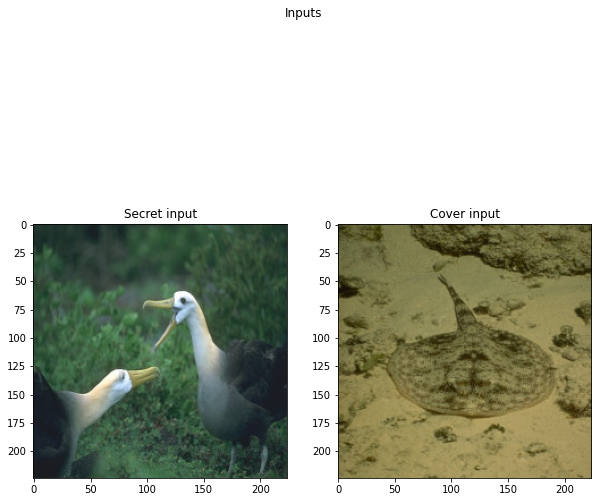

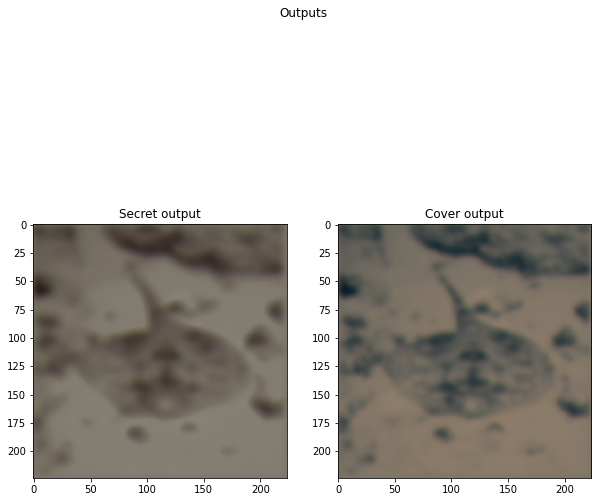

In [ ]:
import numpy as np
import random
import keras
import glob
import sys
import os
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from pathlib import Path

'''
Evaluates the trained model on a new dataset
Uses Mean Square Error as evaluation metric
'''

# Path for evaluation dataset
EVAL_PATH = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/dataset/eval_data"
BATCH_SIZE=1
TEST_NUM=len(glob.glob(str(EVAL_PATH)))

# Normalize input for evaluation
def normalize_batch(imgs):

    return (imgs -  np.array([0.485, 0.456, 0.406])) /np.array([0.229, 0.224, 0.225])

# Denormalize output for prediction
def denormalize_batch(imgs,should_clip=True):

    imgs= (imgs * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])

    if should_clip:
        imgs= np.clip(imgs,0,1)
    return imgs

# Create a data generator for evaluation
test_imgen = ImageDataGenerator(rescale = 1./255)

# Compute L2 loss(MSE) for secret image
def custom_loss_1(secret,secret_pred):
    secret_mse = keras.losses.mean_squared_error(secret,secret_pred)
    return secret_mse

# Compute L2 loss(MSE) for cover image
def custom_loss_2(cover,cover_pred):
    cover_mse = keras.losses.mean_squared_error(cover,cover_pred)
    return cover_mse
tr_data = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/checkpoints/steg_model-06-0.03.hdf5"
# Load the trained model
model=load_model(tr_data, custom_objects={'custom_loss_1': custom_loss_1, 'custom_loss_2': custom_loss_2} )

# Custom data generator
def generate_generator_multiple(generator, direc):
    genX1 = generator.flow_from_directory(direc, target_size=(224,224), batch_size = 12, shuffle=True, seed=3, class_mode=None)
    genX2 = generator.flow_from_directory( direc, target_size=(224, 224), batch_size = 12, shuffle=True, seed=8, class_mode=None)

    while True:
            X1i = normalize_batch(genX1.next())
            X2i = normalize_batch(genX2.next())

            yield( {'secret': X1i, 'cover': X2i}, {'hide_conv_f': X2i, 'revl_conv_f': X1i})  #Yield both images and their mutual label

# Load data using generator
testgenerator=generate_generator_multiple(test_imgen, direc=EVAL_PATH)

# Evaluates the model using data generator
score = model.evaluate_generator(testgenerator,steps=TEST_NUM/BATCH_SIZE, verbose=0)

# Print mean square error
print('Mean square error:', score[0])


'''
Test the model on a  random pair of images (test)
Plots the input and output for verification
'''

# Perform prediction for single input
def predict(source,cover):

   # Normalize inputs
   secret=np.array(source/255.0)
   cover=np.array(cover/255.0)

   # Predict output
   coverout, secretout=model.predict([normalize_batch(np.reshape(secret,(1,224,224,3))),normalize_batch(np.reshape(cover,(1,224,224,3)))])

   # Postprocess output cover image
   coverout = denormalize_batch(coverout)
   coverout=np.squeeze(coverout)*255.0
   coverout=np.uint8(coverout)

   # Postprocess output secret image
   secretout=denormalize_batch(secretout)
   secretout=np.squeeze(secretout)*255.0
   secretout=np.uint8(secretout)

   # Plot output images
   fig_out, ax_out = plt.subplots(1,2, figsize=(10,10))
   fig_out.suptitle('Outputs')
   ax_out[0].title.set_text("Secret output")
   ax_out[0].imshow(secretout)
   ax_out[1].title.set_text("Cover output")
   ax_out[1].imshow(coverout)

# Load random test image pairs
sec,cov=random.sample(os.listdir(str(EVAL_PATH)),k=2)

source=np.array(Image.open(str(EVAL_PATH)+'/'+sec))
cover=np.array(Image.open(str(EVAL_PATH)+'/'+cov))

# Plot input images
fig_in, ax_in = plt.subplots(1,2, figsize=(10,10))
fig_in.suptitle('Inputs')
ax_in[0].title.set_text("Secret input")
ax_in[0].imshow(source)
ax_in[1].title.set_text("Cover input")
ax_in[1].imshow(cover)

# Perform prediction
predict(source,cover)

# Sample run: python eval.py dataset/eval_data checkpoints/steg_model-06-0.03.hdf5


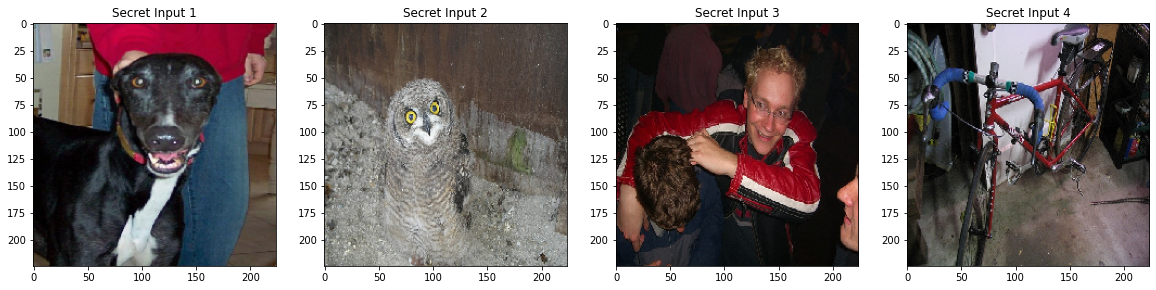

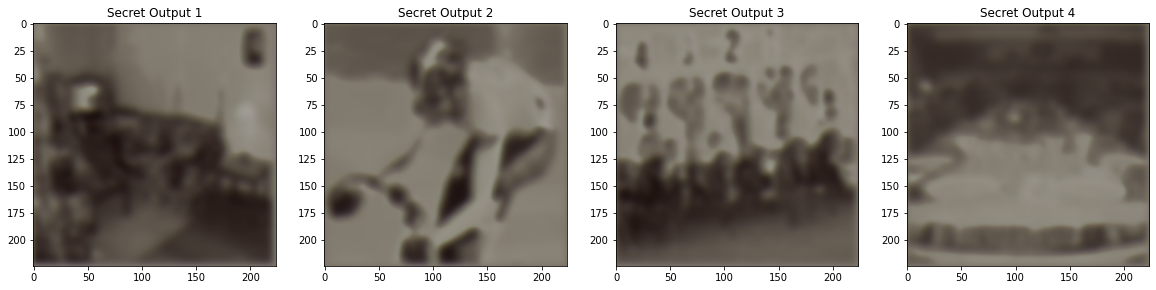

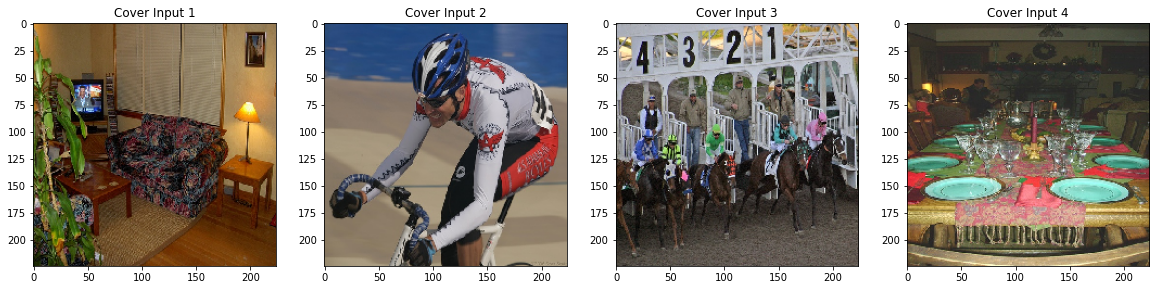

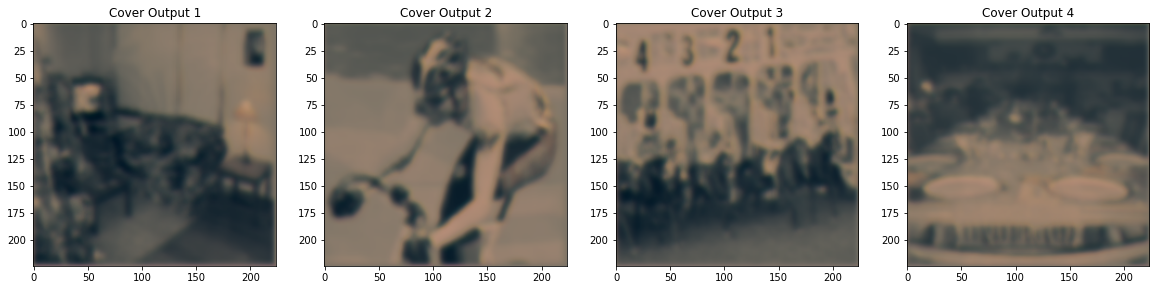

In [ ]:
import numpy as np
import keras
import sys
from keras.models import Model
# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model

from keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
from random import randint
import imageio
from skimage.util.shape import view_as_blocks
%matplotlib inline

'''
Test the model on sample images (unseen)
Plot the input and output images
'''
arg1 = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/test/testdata.npy"
arg2 = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/checkpoints/steg_model-06-0.03.hdf5"
# Load test images
test_images=np.load(arg1)

# Load model
model=load_model(arg2,compile=False)

# Normalize inputs
def normalize_batch(imgs):
    '''Performs channel-wise z-score normalization'''

    return (imgs -  np.array([0.485, 0.456, 0.406])) /np.array([0.229, 0.224, 0.225])

# Denormalize outputs
def denormalize_batch(imgs,should_clip=True):
    imgs= (imgs * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])

    if should_clip:
        imgs= np.clip(imgs,0,1)
    return imgs

# Load images as batch (batch size -4)
secretin = test_images[np.random.choice(len(test_images), size=4, replace=False)]
coverin = test_images[np.random.choice(len(test_images), size=4, replace=False)]

# Perform batch prediction
coverout, secretout=model.predict([normalize_batch(secretin),normalize_batch(coverin)])

# Postprocess cover output
coverout = denormalize_batch(coverout)
coverout=np.squeeze(coverout)*255.0
coverout=np.uint8(coverout)

# Postprocess secret output
secretout=denormalize_batch(secretout)
secretout=np.squeeze(secretout)*255.0
secretout=np.uint8(secretout)

# Convert images to UINT8 format (0-255)
coverin=np.uint8(np.squeeze(coverin*255.0))
secretin=np.uint8(np.squeeze(secretin*255.0))

# Plot the images
def plot(im, title):
    fig = plt.figure(figsize=(20, 20))

    for i in range(4):
        sub = fig.add_subplot(1, 4, i + 1)
        sub.title.set_text(title + " " + str(i+1))
        sub.imshow(im[i,:,:,:])

# Plot secret input and output
plot(secretin, "Secret Input")
plot(secretout, "Secret Output")

# Plot cover input and output
plot(coverin, "Cover Input")
plot(coverout, "Cover Output")


# Sample run: python test.py test/testdata.npy checkpoints/steg_model-06-0.03.hdf5


In [ ]:
import sys
from keras.models import Model
from keras.layers import Dense, Input, concatenate, Conv2D
from keras.models import load_model
from keras.utils.vis_utils import plot_model

arg1= "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/checkpoints/steg_model-06-0.03.hdf5"
# Load complete model
model=load_model(arg1, compile=False)

# Print model summary
model.summary()

# Generate hiding network
encoder=Model([model.get_layer('secret').input,model.get_layer('cover').input],model.get_layer('hide_conv_f').output)
encoder.save("hide.h5")

# Save model plot
plot_model(encoder, to_file='hide.png')

# Create new input layer
new_ip=Input(shape=(224,224,3))

# Reveal network [Re-initialize layer and weights]
rconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='revl_conv3x3_1')(new_ip)
rconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='revl_conv3x3_2')(rconv_3x3)
rconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='revl_conv3x3_3')(rconv_3x3)
rconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='revl_conv3x3_4')(rconv_3x3)

rconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='revl_conv4x4_1')(new_ip)
rconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='revl_conv4x4_2')(rconv_4x4)
rconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='revl_conv4x4_3')(rconv_4x4)
rconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='revl_conv4x4_4')(rconv_4x4)

rconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='revl_conv5x5_1')(new_ip)
rconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='revl_conv5x5_2')(rconv_5x5)
rconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='revl_conv5x5_3')(rconv_5x5)
rconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='revl_conv5x5_4')(rconv_5x5)

rconcat_1 = concatenate([rconv_3x3,rconv_4x4,rconv_5x5], axis=3, name="revl_concat_1")

rconv_5x5=Conv2D(50, kernel_size=5, padding="same", activation='relu', name='revl_conv5x5_f')(rconcat_1)
rconv_4x4=Conv2D(50, kernel_size=4, padding="same", activation='relu', name='revl_conv4x4_f')(rconcat_1)
rconv_3x3=Conv2D(50, kernel_size=3, padding="same", activation='relu', name='revl_conv3x3_f')(rconcat_1)

rconcat_f1 = concatenate([rconv_5x5,rconv_4x4,rconv_3x3], axis=3, name="revl_concat_2")

secret_pred = Conv2D(3, kernel_size=1, padding="same", name='revl_conv_f')(rconcat_f1)

# Generate reveal network
decoder=Model(new_ip,secret_pred)

# Load weights from the parent model
decoder.load_weights(arg1, by_name=True)
decoder.save('reveal.h5')

#Save model plot
plot_model(decoder, to_file='reveal.png')

'''
Sample run:-
python split_model.py checkpoints/steg_model-06-0.03.hdf5
'''


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 secret (InputLayer)            [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 prep_conv3x3_1 (Conv2D)        (None, 224, 224, 50  1400        ['secret[0][0]']                 
                                )                                                                 
                                                                                                  
 prep_conv4x4_1 (Conv2D)        (None, 224, 224, 50  2450        ['secret[0][0]']                 
                                )                                                             

'\nSample run:-\npython split_model.py checkpoints/steg_model-06-0.03.hdf5\n'

1/1 [==============================] - 5s 5s/step


'\nSample run :-\n# Without shuffle\npython image_hide.py --model models/hide.h5 --secret_image test/cover.png --cover_image test/secret.png\n# With shuffle\npython image_hide.py --model models/hide.h5 --secret_image test/cover.png  --cover_image test/cover.png  --shuffle \n'

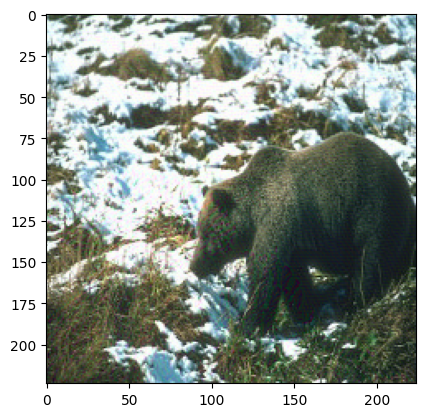

In [ ]:
import numpy as np
import keras
import sys
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
from random import randint
import imageio
import argparse
from skimage.util.shape import view_as_blocks

model = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/models/hide.h5"
# cover_image = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/test/cover.png"
# secret_image = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/test/secret.png"
cover_image = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/test/images/100098.jpg"
secret_image = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/test/images/101027.jpg"
# # Construct argument parser
# parser = argparse.ArgumentParser(description='Use block shuffle')
# parser.add_argument('--shuffle', action='store_true', default=False)
# parser.add_argument("--model", required=True, help="path to trained model")
# parser.add_argument("--secret_image", required=True, help="path to secret image")
# parser.add_argument("--cover_image", required=True, help="path to cover image")
# args= vars(parser.parse_args())

'''
Hides secret image inside cover image
Input: Secret Image, Cover Image, Hide Model
Output: Container Image
'''

# Load the model
model_hide=load_model(model,compile=False)

# Normalize inputs
def normalize_batch(imgs):
    '''Performs channel-wise z-score normalization'''

    return (imgs -  np.array([0.485, 0.456, 0.406])) /np.array([0.229, 0.224, 0.225])

# Denormalize outputs
def denormalize_batch(imgs,should_clip=True):
    imgs= (imgs * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])

    if should_clip:
        imgs= np.clip(imgs,0,1)
    return imgs

# Custom block shuffling
def shuffle(img, inverse = False):

  # Configure block size, rows and columns
  blk_size=56
  rows=np.uint8(img.shape[0]/blk_size)
  cols=np.uint8(img.shape[1]/blk_size)

  # Create a block view on image
  img_blks=view_as_blocks(img,block_shape=(blk_size,blk_size,3)).squeeze()
  img_shuff=np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)

  # Secret key maps
  map={0:2, 1:0, 2:3, 3:1}
  inv_map = {v: k for k, v in map.items()}

  # Perform block shuffling
  for i in range(0,rows):
    for j in range(0,cols):
     x,y = i*blk_size, j*blk_size
     if(inverse):
      img_shuff[x:x+blk_size, y:y+blk_size] = img_blks[inv_map[i],inv_map[j]]
     else:
      img_shuff[x:x+blk_size, y:y+blk_size] = img_blks[map[i],map[j]]

  return img_shuff

# Normalize input images [float: 0-1]
secretin = np.array(Image.open(secret_image).convert('RGB')).reshape(1,224,224,3)/255.0
coverin = np.array(Image.open(cover_image).convert('RGB')).reshape(1,224,224,3)/255.0
shufflee = False
# Shuffle secret input
if(shufflee==True):
    secretin[0]=shuffle(secretin[0], inverse = False)

# Predict the output
coverout=model_hide.predict([normalize_batch(secretin),normalize_batch(coverin)])

# Postprocess the output
coverout = denormalize_batch(coverout)
coverout=np.squeeze(coverout)*255.0
coverout=np.uint8(coverout)

# Save and plot stego-image output (container image)
imageio.imsave('/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/test/containerOM.png',coverout)
plt.imshow(coverout)

'''
Sample run :-
# Without shuffle
python image_hide.py --model models/hide.h5 --secret_image test/cover.png --cover_image test/secret.png
# With shuffle
python image_hide.py --model models/hide.h5 --secret_image test/cover.png  --cover_image test/cover.png  --shuffle
'''


[[[[0.62352941 0.71372549 0.6627451 ]
   [0.56470588 0.65490196 0.60784314]
   [0.3372549  0.39607843 0.34117647]
   ...
   [0.59607843 0.74509804 0.83137255]
   [0.63137255 0.83529412 0.87843137]
   [0.64313725 0.78823529 0.83921569]]

  [[0.6        0.69803922 0.66666667]
   [0.43529412 0.52941176 0.44705882]
   [0.26666667 0.36078431 0.24705882]
   ...
   [0.47058824 0.64313725 0.70588235]
   [0.50980392 0.72941176 0.71764706]
   [0.59215686 0.77647059 0.79607843]]

  [[0.41568627 0.49411765 0.50196078]
   [0.29803922 0.36470588 0.39215686]
   [0.23529412 0.29411765 0.23137255]
   ...
   [0.5254902  0.6627451  0.7254902 ]
   [0.4        0.54117647 0.69019608]
   [0.44705882 0.62352941 0.69803922]]

  ...

  [[0.13333333 0.10588235 0.1372549 ]
   [0.16078431 0.19607843 0.11764706]
   [0.2        0.16862745 0.14117647]
   ...
   [0.38039216 0.38039216 0.35686275]
   [0.19215686 0.21960784 0.09411765]
   [0.14509804 0.16078431 0.17254902]]

  [[0.15686275 0.19607843 0.14117647]
   [0.1

'\nSample run :-\n# Without shuffle\npython image_reveal.py --model models/reveal.h5 --container_image test/cover_output.png\n# With shuffle\npython image_reveal.py --model models/reveal.h5 --container_image test/cover_output.png --shuffle \n'

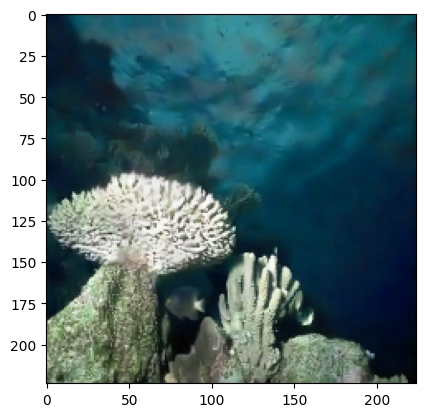

In [ ]:
import numpy as np
import keras
import sys
from keras.models import Model
# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model

from keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
from random import randint
import imageio
import argparse
from skimage.util.shape import view_as_blocks

# # Construct argument parser
# parser = argparse.ArgumentParser(description='Use block shuffle')
# parser.add_argument('--shuffle', action='store_true', default=False)
# parser.add_argument("--model", required=True, help="path to trained model")
# parser.add_argument("--container_image", required=True, help="path to container image")
# args= vars(parser.parse_args())

'''
Retrieves secret image from container image
Input: Container Image, Reveal Model
Output: Secret Image
'''
model = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/models/reveal.h5"
coverout = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/test/containerOM.png"
# Load the model
model_reveal=load_model(model,compile=False)
# Normalize inputs
def normalize_batch(imgs):
    '''Performs channel-wise z-score normalization'''

    return (imgs -  np.array([0.485, 0.456, 0.406])) /np.array([0.229, 0.224, 0.225])

# Denormalize outputs
def denormalize_batch(imgs,should_clip=True):
    imgs= (imgs * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])

    if should_clip:
        imgs= np.clip(imgs,0,1)
    return imgs

# Custom block shuffling
def shuffle(img, inverse = False):

  # Configure block size, rows and columns
  blk_size=56
  rows=np.uint8(img.shape[0]/blk_size)
  cols=np.uint8(img.shape[1]/blk_size)

  # Create a block view on image
  img_blks=view_as_blocks(img,block_shape=(blk_size,blk_size,3)).squeeze()
  img_shuff=np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)

  # Secret key maps
  map={0:2, 1:0, 2:3, 3:1}
  inv_map = {v: k for k, v in map.items()}

  # Perform block shuffling
  for i in range(0,rows):
    for j in range(0,cols):
     x,y = i*blk_size, j*blk_size
     if(inverse):
      img_shuff[x:x+blk_size, y:y+blk_size] = img_blks[inv_map[i],inv_map[j]]
     else:
      img_shuff[x:x+blk_size, y:y+blk_size] = img_blks[map[i],map[j]]

  return img_shuff
# Normalize input images [float: 0-1]

stego_image = np.array(Image.open(coverout).convert('RGB')).reshape(1,224,224,3)/255.0
print(stego_image)
# Predict the output
secretout = model_reveal.predict([normalize_batch(stego_image)])

# Postprocess the output
secretout = denormalize_batch(secretout)
secretout=np.squeeze(secretout)*255.0
secretout=np.uint8(secretout)
shufflee = False
# Reshuffle the output
if(shufflee==True):
   secretout=shuffle(secretout, inverse = True)

# Save and plot stego image output
imageio.imsave("/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/test/secretCHH.png",secretout)
plt.imshow(secretout)

'''
Sample run :-
# Without shuffle
python image_reveal.py --model models/reveal.h5 --container_image test/cover_output.png
# With shuffle
python image_reveal.py --model models/reveal.h5 --container_image test/cover_output.png --shuffle
'''


In [ ]:
import os
import numpy as np
import keras
import cv2
import math
import sys
from keras.models import Model
from keras.models import load_model
from PIL import Image
import argparse
# from scipy.misc import imsave
import imageio

from skimage.util.shape import view_as_blocks

# # Construct argument parser
# parser = argparse.ArgumentParser(description='Use block shuffle')
# parser.add_argument('--shuffle', action='store_true', default=False)
# parser.add_argument("--model", required=True, help="path to trained model")
# parser.add_argument("--secret_video", required=True, help="path to secret video")
# parser.add_argument("--cover_video", required=True, help="path to cover video")
# args= vars(parser.parse_args())

model = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/models/hide.h5"
# secret_video = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/videos/secret.mp4"
# cover_video = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/videos/cover.mp4"

# secret_video = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/videos/Secret1.mp4"
# cover_video = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/videos/Cover1.mp4"

secret_video = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/videos/armyS_secret.mp4"
cover_video = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/videos/armyS_cover.mp4"



# Normalize input images
def normalize_batch(imgs):
    return (imgs -  np.array([0.485, 0.456, 0.406])) /np.array([0.229, 0.224, 0.225])

# Denormalize output images
def denormalize_batch(imgs,should_clip=True):
    imgs= (imgs * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])

    if should_clip:
        imgs= np.clip(imgs,0,1)
    return imgs

# Custom block shuffling
def shuffle(img, inverse = False):

  # Configure block size, rows and columns
  blk_size=56
  rows=np.uint8(img.shape[0]/blk_size)
  cols=np.uint8(img.shape[1]/blk_size)

  # Create a block view on image
  img_blks=view_as_blocks(img,block_shape=(blk_size,blk_size,3)).squeeze()
  img_shuff=np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)

  # Secret key maps
  map={0:2, 1:0, 2:3, 3:1}
  inv_map = {v: k for k, v in map.items()}

  # Perform block shuffling
  for i in range(0,rows):
    for j in range(0,cols):
     x,y = i*blk_size, j*blk_size
     if(inverse):
      img_shuff[x:x+blk_size, y:y+blk_size] = img_blks[inv_map[i],inv_map[j]]
     else:
      img_shuff[x:x+blk_size, y:y+blk_size] = img_blks[map[i],map[j]]

  return img_shuff

# Update progress bar
def update_progress(current_frame, total_frames):
    progress=math.ceil((current_frame/total_frames)*100)
    sys.stdout.write('\rProgress: [{0}] {1}%'.format('>'*math.ceil(progress/10), progress))

# Load the trained model
model=load_model(model,compile=False)

# Input videos - Secret and Cover
vidcap1 = cv2.VideoCapture(secret_video)
vidcap2 = cv2.VideoCapture(cover_video)

# Start video encoding
print("\nEncoding video ...\n")

# Total secret video frames
num_frames = int(vidcap1.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total frames in secret video:", num_frames)

# Video writer for output
container_outvid = cv2.VideoWriter('/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/results/cover_outvideoArmyS_224.avi',cv2.VideoWriter_fourcc('H','F','Y','U'), 15, (224,224))

# Temporary buffers for batching
secret_batch=[]
cover_batch=[]
frame = 0

# Process frames as batches
while True:

        # Read frames sequentially
        (success1, secret) = vidcap1.read()
        (success2, cover) = vidcap2.read()

        if not (success1 and success2):
            break

        # Preprocess frames
        secret = cv2.resize(cv2.cvtColor(secret, cv2.COLOR_BGR2RGB), (224,224) ,interpolation=cv2.INTER_AREA)
        cover = cv2.resize(cv2.cvtColor(cover, cv2.COLOR_BGR2RGB), (224,224) ,interpolation=cv2.INTER_AREA)
        shufflee = True
        # Perform block shuffle
        if(shufflee==True):
          print("Shuffling ...")
          secret=shuffle(secret, inverse = False)

        # Append frames to buffer
        secret_batch.append(secret)
        cover_batch.append(cover)
        #print("Batching...")
        frame = frame + 1

        # Perform batch prediction
        if frame % 4 == 0  :

            # Convert images to float type
            secret_batch = np.float32(secret_batch)/255.0
            cover_batch = np.float32(cover_batch)/255.0

            # Save image for testing
            imageio.imsave("test.png",secret_batch[0])

            # Predict outputs
            coverout=model.predict([normalize_batch(secret_batch),normalize_batch(cover_batch)])

            # Postprocess cover image output
            coverout = denormalize_batch(coverout)
            coverout=np.squeeze(coverout)*255.0
            coverout=np.uint8(coverout)

            # Save cover output video
            for i in range(0,4):
               #imsave("coverout.png",frame)
               container_outvid.write(coverout[i][..., ::-1])

            # Empty temporary buffers
            secret_batch=[]
            cover_batch=[]

            # Update progress
            update_progress(frame, num_frames)

# Finish video encoding
print("\n\nSuccessfully encoded video !!!\n")

# Close video capturers
vidcap1.release()
vidcap2.release()
cv2.destroyAllWindows()

'''
Sample run :-
# Without shuffle
python video_hide.py --model models/hide.h5 --secret_video videos/secret.mp4 --cover_video videos/cover.mp4
# With shuffle
python video_hide.py --model models/hide.h5 --secret_video videos/secret.mp4 --cover_video videos/cover.mp4 --shuffle
'''



Encoding video ...

Total frames in secret video: 290
Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 14s 14s/step


Progress: [>] 2%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>] 3%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>] 5%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>] 6%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 14s 14s/step


Progress: [>] 7%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>] 9%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 14s 14s/step


Progress: [>] 10%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>] 12%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>] 13%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>] 14%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>] 16%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>] 17%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>] 18%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>] 20%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>] 21%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>] 23%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>] 24%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>] 25%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>] 27%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>] 28%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>] 29%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>] 31%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>] 32%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>] 34%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>] 35%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>] 36%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>] 38%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>] 39%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>] 40%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>] 42%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>] 43%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>] 45%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>] 46%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>] 47%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>] 49%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>] 50%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>] 52%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>] 53%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>] 54%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>] 56%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>] 57%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>] 58%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>] 60%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>] 61%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>] 63%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>] 64%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>] 65%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 14s 14s/step


Progress: [>>>>>>>] 67%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>] 68%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>] 69%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>] 71%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>] 72%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>] 74%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>] 75%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>] 76%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>] 78%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>] 79%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>] 80%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>>] 82%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>>] 83%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>>] 85%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>>] 86%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>>] 87%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>>] 89%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>>] 90%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>>>] 92%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>>>] 93%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>>>] 94%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>>>] 96%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>>>] 97%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step


Progress: [>>>>>>>>>>] 98%Shuffling ...
Shuffling ...
Shuffling ...
Shuffling ...
1/1 [==============================] - 13s 13s/step
Progress: [>>>>>>>>>>] 100%Shuffling ...
Shuffling ...


Successfully encoded video !!!



'\nSample run :-\n# Without shuffle\npython video_hide.py --model models/hide.h5 --secret_video videos/secret.mp4 --cover_video videos/cover.mp4\n# With shuffle\npython video_hide.py --model models/hide.h5 --secret_video videos/secret.mp4 --cover_video videos/cover.mp4 --shuffle \n'

In [ ]:
import os
import numpy as np
import keras
import cv2
import sys
import math
from keras.models import Model
from keras.models import load_model
from PIL import Image
import argparse
# from scipy.misc import imsave
import imageio

from skimage.util.shape import view_as_blocks

# # Construct argument parser
# parser = argparse.ArgumentParser(description='Use block shuffle')
# parser.add_argument('--shuffle', action='store_true', default=False)
# parser.add_argument("--model", required=True, help="path to trained model")
# parser.add_argument("--container_video", required=True, help="path to container video")
# args= vars(parser.parse_args())

model = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/models/reveal.h5"
# container_video_final = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/results/cover_outvideo_final_224.avi"
# cover_outvideo_final1_224 = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/results/cover_outvideo_final1_224.avi"
# container_video = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/results/cover_outvideog1_224.avi"
# container_vid = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/results/cover_outvideog1_224.avi"

# container_video = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/results/cover_outvideog2_224.avi"
# container_outvid = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/results/cover_outvideog2_224.avi"
container_outvid = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/results/cover_outvideoArmyS_224.avi"

# Normalize input images
def normalize_batch(imgs):
    return (imgs -  np.array([0.485, 0.456, 0.406])) /np.array([0.229, 0.224, 0.225])

# Denormalize output images
def denormalize_batch(imgs,should_clip=True):
    imgs= (imgs * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])

    if should_clip:
        imgs= np.clip(imgs,0,1)
    return imgs

# Custom block shuffling
def shuffle(img, inverse = False):

  # Configure block size, rows and columns
  blk_size=56
  rows=np.uint8(img.shape[0]/blk_size)
  cols=np.uint8(img.shape[1]/blk_size)

  # Create a block view on image
  img_blks=view_as_blocks(img,block_shape=(blk_size,blk_size,3)).squeeze()
  img_shuff=np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)

  # Secret key maps
  map={0:2, 1:0, 2:3, 3:1}
  inv_map = {v: k for k, v in map.items()}

  # Perform block shuffling
  for i in range(0,rows):
    for j in range(0,cols):
     x,y = i*blk_size, j*blk_size
     if(inverse):
      img_shuff[x:x+blk_size, y:y+blk_size] = img_blks[inv_map[i],inv_map[j]]
     else:
      img_shuff[x:x+blk_size, y:y+blk_size] = img_blks[map[i],map[j]]

  return img_shuff

# Update progress bar
def update_progress(current_frame, total_frames):
    # print(total_frames)
    progress=math.ceil((current_frame/total_frames)*100)
    sys.stdout.write('\rProgress: [{0}] {1}%'.format('>'*math.ceil(progress/10), progress))

# Load the trained model
model=load_model(model,compile=False)

# Input videos - Container Video
vidcap1 = cv2.VideoCapture(container_outvid)
# Start video decoding
print("\nDecoding video ...\n")

# Total secret video frames
num_frames = int(vidcap1.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total frames in container video:", num_frames)


# Video writer for output
secret_outvid = cv2.VideoWriter('/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/results/secret_outvideoArmyS_300.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 15, (300,300))

# Temporary buffers for batching
cover_batch=[]
frame = 0
print("Processing frames..")
# Process frames as batches
while True:
        print("Loop..")
        # Read frames sequentially
        (success, cover) = vidcap1.read()

        if not (success):
            break
        print("Processing..")
        # Preprocess frames
        cover = cv2.cvtColor(cover, cv2.COLOR_BGR2RGB)

        # Append frames to buffer
        cover_batch.append(cover)
        #print("Processing batch: ", batch)
        frame = frame + 1

        # Perform batch prediction
        if frame % 4 == 0  :

            # Convert images to float type
            cover_batch = np.float32(cover_batch)/255.0

            # Save image for testing
            imageio.imsave("test.png",cover_batch[0])

            # Predict outputs
            secretout=model.predict([normalize_batch(cover_batch)])

            # Postprocess secret image output
            secretout=denormalize_batch(secretout)
            secretout=np.squeeze(secretout)*255.0
            secretout=np.uint8(secretout)
            shufflee = True
             # Save secret output video
            for i in range(0,4):
               #imsave("seretout.png",frame)
               if(shufflee==True):
                 secretout[i]=shuffle(secretout[i], inverse = True)
               secret_outvid.write(cv2.resize(secretout[i][..., ::-1], (300,300), interpolation=cv2.INTER_CUBIC))

            # Empty temporary buffers
            cover_batch=[]
            print("num_frames", num_frames)
            # Update progress
            update_progress(frame, num_frames)

# Finish video decoding
print("\n\nSuccessfully decoded video !!!\n")

# Close video capturers
vidcap1.release()
cv2.destroyAllWindows()

'''
Sample run :-
# Without shuffle
python video_reveal.py --model models/reveal.h5 --container_video results/cover_outvid_224.avi
# With shuffle
python video_reveal.py --model models/reveal.h5 --container_video results/cover_outvid_224.avi --shuffle
'''



Decoding video ...

Total frames in container video: 288
Processing frames..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>] 2%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>] 3%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>] 5%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>] 6%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>] 7%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>] 9%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>] 10%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>] 12%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>] 13%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>] 14%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>] 16%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>] 17%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>] 19%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>] 20%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>] 21%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>] 23%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>] 24%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>] 25%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>] 27%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step
num_frames 288
Progress: [>>>] 28%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..


Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>] 30%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>] 31%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>] 32%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>] 34%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>] 35%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>] 37%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>] 38%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>] 39%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>] 41%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>] 42%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>] 44%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>] 45%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>] 46%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>] 48%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>] 49%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>] 50%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>] 52%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>] 53%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>] 55%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>] 56%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>] 57%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>] 59%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>] 60%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>>] 62%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>>] 63%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>>] 64%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>>] 66%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>>] 67%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>>] 69%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>>] 70%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>>>] 71%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>>>] 73%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>>>] 74%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>>>] 75%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>>>] 77%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>>>] 78%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>>>] 80%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>>>>] 81%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>>>>] 82%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>>>>] 84%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>>>>] 85%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>>>>] 87%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>>>>] 88%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>>>>] 89%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>>>>>] 91%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>>>>>] 92%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>>>>>] 94%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>>>>>] 95%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>>>>>] 96%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step


num_frames 288
Progress: [>>>>>>>>>>] 98%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 6s 6s/step


num_frames 288
Progress: [>>>>>>>>>>] 99%Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
Loop..
Processing..
1/1 [==============================] - 5s 5s/step
num_frames 288
Progress: [>>>>>>>>>>] 100%Loop..


Successfully decoded video !!!



'\nSample run :-\n# Without shuffle\npython video_reveal.py --model models/reveal.h5 --container_video results/cover_outvid_224.avi\n# With shuffle\npython video_reveal.py --model models/reveal.h5 --container_video results/cover_outvid_224.avi --shuffle \n'

In [ ]:
import numpy as np
import argparse
import sys
import math
from PIL import ImageFilter, Image
import cv2

'''
Enhance video by applying denoise and sharpen filters
'''

# # Construct argument parser
# parser = argparse.ArgumentParser(description='Use block shuffle')
# parser.add_argument('--denoise', action='store_true', default=False)
# parser.add_argument('--sharpen', action='store_true', default=False)
# parser.add_argument("--input_video", required=True, help="path to input video")
# args= vars(parser.parse_args())
input_video = "/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/results/secret_outvideog2_300.avi"
# Start video enhancement
print('\nEnhancing video ...\n')

# Update progress bar
def update_progress(current_frame, total_frames):
    progress=math.ceil((current_frame/total_frames)*100)
    sys.stdout.write('\rProgress: [{0}] {1}%'.format('>'*math.ceil(progress/10), progress))

# Open the input video
vidcap = cv2.VideoCapture(input_video)

# Total input video frames
num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total frames in input video:", num_frames)

# Initialize the video writer
enhanced_video = cv2.VideoWriter('/content/drive/MyDrive/Deep-Video-Steganography-Hiding-Videos-in-Plain-Sight-master/results/enhanced_secret_300.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 15, (300,300))

# Initialize the frame buffer
frames=[]

# Load the frames to buffer
while vidcap.isOpened():
  success,image = vidcap.read()
  if success:
     frames.append(image)
  else:
      break

# Set up the start frame index
start_frame=5
denoise = True
sharpen = True
# Enhance and save video frame-by-frame
for i in range(start_frame,len(frames)-(start_frame+1)):
   output=frames[i]
   if(denoise==True):
      output = cv2.fastNlMeansDenoisingColoredMulti(frames, i, 11)
   if(sharpen==True):
       output = np.array( Image.fromarray(output).filter(ImageFilter.DETAIL) )
   enhanced_video.write(output)
   update_progress(i, num_frames-(start_frame+1))

# Finish video enhancement
print('\n\nSuccessfully enhanced video !!!\n')

'''
Sample run:-
python enhance.py --input_video results/secret_outvid_300.avi --denoise --sharpen
'''



Enhancing video ...

Total frames in input video: 0
Progress: [] -683%

KeyboardInterrupt: ignored